In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape

/home/kk/dl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 10
epsilon_std = 1.0

In [3]:
#encoder part
x = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [4]:
#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_decoded_mean = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28


# instantiate VAE model
vae = Model(x, x_decoded_mean)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [5]:
# Compute VAE loss
x_in=Reshape([original_dim,])(x)
x_out=Reshape([original_dim,])(x_decoded_mean)
xent_loss = original_dim * metrics.binary_crossentropy(x_in, x_out)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam', loss='')

/home/kk/dl/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Output "conv2d_transpose_8" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_8" during training.
  if __name__ == '__main__':


In [6]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_num=50000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
x_valid = x_train[train_num:-1]
x_train = x_train[1:train_num]
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_valid, None))

# display a 2D plot of the digit classes in the latent space
#x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

Train on 49999 samples, validate on 9999 samples
Epoch 1/10
49999/49999 [==============================] - 50s 1ms/step - loss: 231.9709 - val_loss: 162.8314
Epoch 2/10
49999/49999 [==============================] - 47s 943us/step - loss: 140.4280 - val_loss: 129.5112
Epoch 3/10
49999/49999 [==============================] - 45s 907us/step - loss: 125.0084 - val_loss: 122.2757
Epoch 4/10
49999/49999 [==============================] - 45s 907us/step - loss: 120.4250 - val_loss: 118.6639
Epoch 5/10
49999/49999 [==============================] - 45s 906us/step - loss: 118.0117 - val_loss: 117.2834
Epoch 6/10
49999/49999 [==============================] - 46s 913us/step - loss: 116.1148 - val_loss: 116.0728
Epoch 7/10
49999/49999 [==============================] - 45s 910us/step - loss: 115.0458 - val_loss: 114.3042
Epoch 8/10
49999/49999 [==============================] - 46s 923us/step - loss: 113.9134 - val_loss: 113.7829
Epoch 9/10
49999/49999 [==============================] - 46s 920

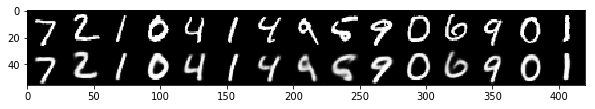

In [11]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * 2, digit_size * n))
xout=vae.predict(x_test[0:batch_size])

for i in range(n):
    figure[0: 28,i * digit_size: (i + 1) * digit_size] = x_test[i].reshape(28,28)
    figure[28: 56,i * digit_size: (i + 1) * digit_size] = xout[i].reshape(28,28)
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()